Валидация модели детекции терминалов

# Загрузка библиотек

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка модели и валидация

In [2]:
model_terminal = YOLO(r'C:\projects\ai_pos_terminal\terminal_object_detection_fixed\runs\detect\train3\weights\best.pt')

In [3]:
df_val = pd.read_pickle("df_val.pkl")

In [6]:
pred[0].boxes.cls.cpu()

tensor([0.])

In [7]:
preds, labels = [], []
for row in tqdm(df_val.iterrows()):
    row = row[1]
    pred = model_terminal.predict(row['filename'], verbose=False)
    preds.append(np.unique(pred[0].boxes.cls.cpu().numpy()))
    labels.append(row['flags'])

392it [00:11, 33.21it/s]


In [8]:
preds_str = []
for label, pred in tqdm(zip(labels, preds)):
    if pred.shape[0]==0:
        preds_str.append('nothing')
        continue
    if pred[0]==0:
        preds_str.append('terminals')
        continue
    if pred[0]==1:
        preds_str.append('pax_im20')
        continue
    if pred[0]==2:
        preds_str.append('new_terminals')

392it [00:00, ?it/s]


In [9]:
df_val.iloc[
    np.where(np.array(preds_str)=='pax_im20')[0], 1
] = 'pax_im20'

In [10]:
cm = confusion_matrix(
    df_val['flags'], preds_str, labels=list(set(preds_str) | set(df_val['flags']))
)

In [11]:
df_cm = pd.DataFrame(
    cm, columns=list(set(preds_str) | set(df_val['flags'])),
    index=list(set(preds_str) | set(df_val['flags']))
)
df_cm = df_cm.replace(0, np.nan).dropna(axis=1, how="all").fillna(0)
df_cm = df_cm.loc[~(df_cm==0).all(axis=1)]
df_cm = df_cm.astype(int)
df_cm

,new_terminals,terminals,nothing
receipts,0,2,124
stickers,0,0,6
pc_screens,0,0,23
other,0,0,18
new_terminals,20,0,0
terminals_side_view,0,2,13
terminals,0,181,0
rack_new_terminal,0,0,3


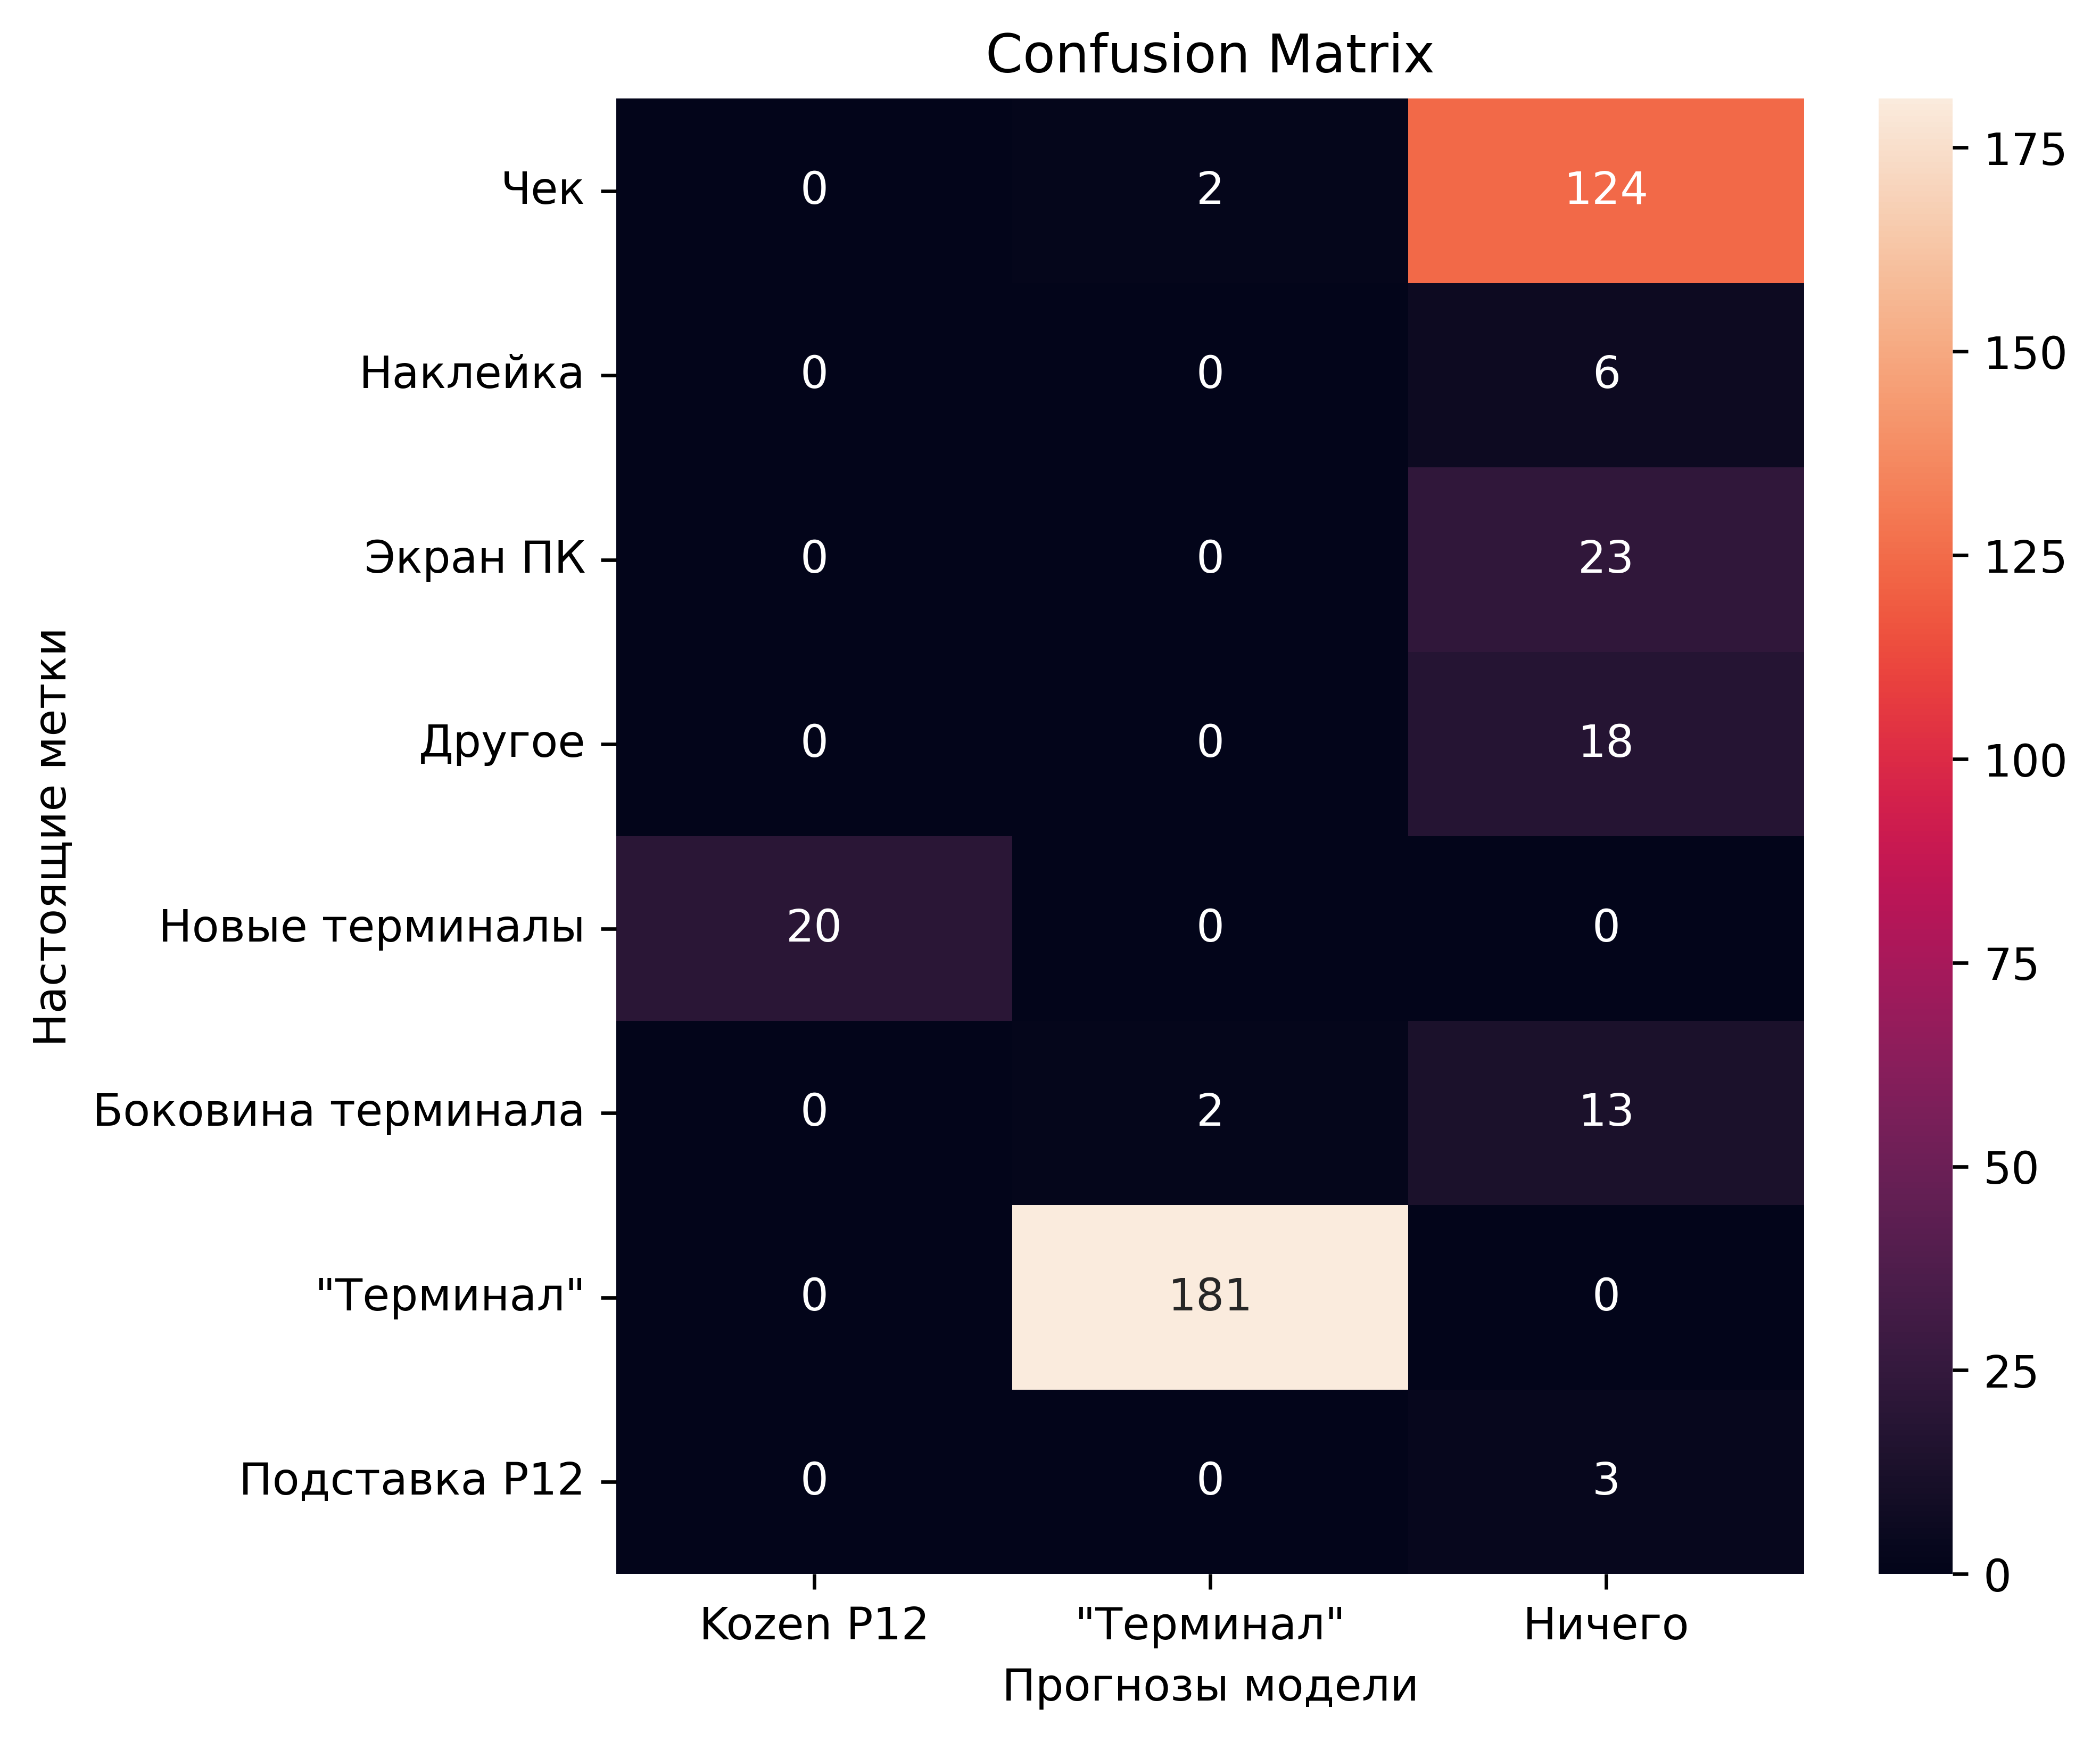

In [13]:
y_labels = ['Чек', 'Наклейка', 'Экран ПК', 'Другое', 'Новые терминалы', 'Боковина терминала', '"Терминал"', 'Подставка P12']
x_labels = ['Kozen P12', '"Терминал"', 'Ничего']
plt.figure(figsize=(6, 6), 
           dpi = 600)
sns.heatmap(df_cm, annot=True, fmt='d',
            xticklabels=x_labels, yticklabels=y_labels, )
plt.title('Confusion Matrix')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()